In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from math import log2

df = pd.read_csv('EPL.csv')

In [13]:
df = df[['HomeTeam', 'AwayTeam', 'FullTimeResult', 'HalfTimeResult']] 
df = df.apply(lambda x: pd.factorize(x)[0])

In [14]:
def entropy(data):
    total = len(data)
    counts = Counter(data)
    return -sum((count/total) * log2(count/total) for count in counts.values())

In [15]:
target_entropy = entropy(df['HalfTimeResult'])
print(f"Dataset Entropy(half): {target_entropy:.4f}")
target_entropy = entropy(df['FullTimeResult'])
print(f"Dataset Entropy(full): {target_entropy:.4f}")

Dataset Entropy(half): 1.5688
Dataset Entropy(full): 1.5392


In [16]:
def information_gain(df, feature, target):
    total_entropy = entropy(df[target])
    values = df[feature].unique()
    weighted_entropy = sum(
        (len(df[df[feature] == v]) / len(df)) * entropy(df[df[feature] == v][target]) 
        for v in values
    )
    return total_entropy - weighted_entropy

In [17]:
info_gains = {feature: information_gain(df, feature, 'FullTimeResult') for feature in df.columns[:-1]}
best_feature = max(info_gains, key=info_gains.get)
print("\nInformation Gain for Each Feature:")
for feature, gain in info_gains.items():
    print(f"{feature}: {gain:.4f}")
print(f"\nBest Feature for Splitting: {best_feature}")


Information Gain for Each Feature:
HomeTeam: 0.0930
AwayTeam: 0.0715
FullTimeResult: 1.5392

Best Feature for Splitting: FullTimeResult


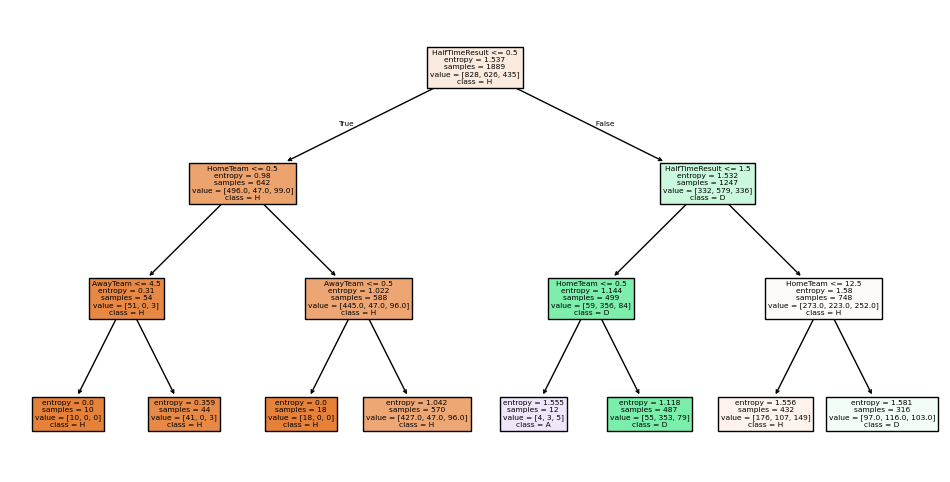

In [18]:
X = df.drop(columns=['FullTimeResult'])
y = df['FullTimeResult']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=10, min_samples_leaf=5)
tree.fit(X_train, y_train)

plt.figure(figsize=(12, 6))
plot_tree(tree, feature_names=X.columns, class_names=['H', 'D', 'A'], filled=True)
plt.show()

In [19]:
importances = tree.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("\nTop Important Features:")
print(feature_importance.head(10))


Top Important Features:
          Feature  Importance
2  HalfTimeResult    0.932996
0        HomeTeam    0.052213
1        AwayTeam    0.014792


In [20]:
y_pred = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5905
Precision: 0.5297
Recall: 0.5905
F1 Score: 0.5145


In [21]:
new_result = {
    'Attribute': 'ID3',
    'Accuracy': accuracy,  
    'Precision': precision, 
    'Recall': recall, 
    'F1 Score': f1    
}

df_existing = pd.read_csv('result.csv')
df_new = pd.DataFrame([new_result])
df_combined = pd.concat([df_existing, df_new], ignore_index=True)
df_combined.to_csv('result.csv', index=False)